In [1]:
import numpy as np
from scipy.optimize import  root as eqsolver
import time
from matplotlib import pyplot as plt

In [2]:
def feasible(f_params,bvec_guess):
    nvec=f_params[0]
    A=f_params[1]
    alpha=f_params[2]
    delta=f_params[3]
    bvec_guess=np.append(0,bvec_guess)
    S=bvec_guess.shape[0]
    
    
    K=np.sum(bvec_guess)
    w=(1-alpha)*A*((K)/np.sum(nvec))**alpha
    r=alpha*A*(np.sum(nvec)/(K))**(1-alpha)-delta
    
    C=np.zeros([S,])
    C[0]=nvec[0]*w-bvec_guess[1]
    for i in range(1,S-1):
        C[i]=nvec[i]*w+(1+r)*bvec_guess[i]-bvec_guess[i+1]
    C[-1]=nvec[-1]*w+(1+r)*bvec_guess[-1]
    
    K_cnstr=K<=0
    c_cnstr=C<=0

    b_cnstr=np.zeros([3,])>np.ones([3,])
    if C[0]==1:
        b_cnstr[0]=True
    for i in range(1,S-1):
        if C[i]==1:
            b_cnstr[i+1]=True
            b_cnstr[i]=True
    if C[-1]==1:
        b_cnstr[-1]=True
        
    return b_cnstr, c_cnstr, K_cnstr   

In [37]:
S=80

bvec_guess1=np.ones([S-1])


bvec_guess2 = np.tile(np.array(\
        [-0.01, 0.1, 0.2, 0.23, 0.25, 0.23, 0.2, 0.1]), 10)
bvec_guess2 =  bvec_guess2[:-1]

bvec_guess3 = np.tile(np.array(\
        [-0.01, 0.1, 0.2, 0.23, 0.25, 0.23, 0.2, 0.1]), 7)
bvec_guess3=np.append(bvec_guess3,np.ones([23,])*.1)



nvec=np.ones([S,])
nvec[np.array(range(S))>round(2*S/3)]=.2
beta = .96
sigma = 3
delta = .05
A = 1
alpha = 0.35
L = np.sum(nvec)

f_params=(nvec,A,A,alpha,delta)

b_cnstr1, c_cnstr1, K_cnstr1 = feasible(f_params,bvec_guess1)
b_cnstr2, c_cnstr2, K_cnstr3 = feasible(f_params,bvec_guess2)
b_cnstr3, c_cnstr3, K_cnstr3 = feasible(f_params,bvec_guess3)

In [4]:
def wage(f_params,k):
    nvec=f_params[0]
    A=f_params[1]
    alpha=f_params[2]
    w=(1-alpha)*A*((k)/np.sum(nvec))**alpha
    return w
def rate(f_params,k):
    nvec=f_params[0]
    A=f_params[1]
    alpha=f_params[2]
    delta=f_params[3]
    r=alpha*A*(np.sum(nvec)/(k))**(1-alpha)-delta
    return r
def u_pr(x,f_params):
    sigma=f_params[5]
    res=(1-sigma)*x**(-sigma)
    return res
def u(x,f_params):
    sigma=f_params[5]
    res=(x**(1-sigma)-1)/(1-sigma)
    return res

In [43]:
def obj(b,f_params):
    nvec=f_params[0]
    beta=f_params[4]
    S=b.shape[0]+1
    V=np.zeros([S-1,])
    k=np.sum(b)
    b=np.append(np.append(0,b),0)
    w=wage(f_params,k)
    r=rate(f_params,k)
    for i in range(1,S):
        
        V[i-1]=u_pr(nvec[i]*w*b[i-1]-b[i],f_params)\
            -beta*(1.+r)*\
            u_pr(nvec[i]*w+(1.+r)*b[i]-b[i+1],f_params)
        
    return V


def get_SS(params,bvec_guess,SS_graphs):
    start_time=time.clock()
    f_params=(params[2],params[4],params[5],params[6],params[0],params[1])
    nvec=f_params[0]
    beta=f_params[4]
    alpha=f_params[2]
    L=params[3]
    A=f_params[1]
    delta=params[3]
    S= bvec_guess.shape[0]+1
    f= lambda b: obj(b,f_params)
    
    b_ss=eqsolver(f,bvec_guess,tol=params[-1]).x
    b_ss=np.append(0,b_ss)
    
    w_ss=wage(f_params,np.sum(b_ss))
    r_ss=rate(f_params,np.sum(b_ss))
    
    c_ss=np.zeros([S,])
    
    c_ss[0]=nvec[0]*w_ss-b_ss[1]
    for i in range(1,S-1):
        c_ss[i]=nvec[i]*w_ss+(1+r_ss)*b_ss[i]-b_ss[i+1]
    c_ss[-1]=nvec[-1]*w_ss+(1+r_ss)*b_ss[-1]
    
    K_ss=np.sum(b_ss)
    Y_ss=(A*K_ss**alpha)*L**(1-alpha)
    EulErr_ss=np.zeros([S,])
    
    for i in range(1,S-1):
        EulErr_ss[i-1]=beta*(1+r_ss)*u_pr(c_ss[i],f_params)-u_pr(c_ss[i-1],f_params)
    C_ss=np.sum(c_ss)
    
    RCerr_ss=Y_ss-C_ss-delta*K_ss
    ss_time=time.clock()-start_time
    ss_output = {
    'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
    'ss_time': ss_time}
    if SS_graphs==True:
        plt.figure(1)
        plt.bar(range(21,S+21),c_ss)
        plt.title("Consumptions")
        plt.figure(2)
        plt.bar(range(21,S+21),b_ss)
        plt.title("Savings")
        plt.show()
    return ss_output 

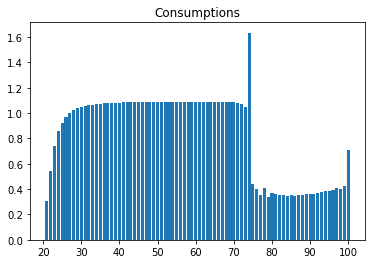

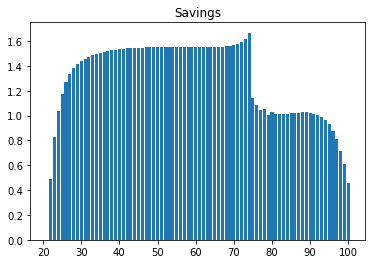

 b_ss  [ 0.          0.4869784   0.83040232  1.03955956  1.1748485   1.26796574
  1.33345366  1.37975226  1.41362628  1.43897136  1.45804658  1.47286402
  1.48501107  1.49516383  1.50388602  1.51153875  1.51826506  1.52412728
  1.52916769  1.53343152  1.53698204  1.53989883  1.54226868  1.54417731
  1.54570388  1.54691823  1.54788006  1.54863919  1.54923665  1.54970569
  1.55007317  1.55036055  1.55058494  1.55075984  1.55089601  1.55100189
  1.55108419  1.55114837  1.55119941  1.55124304  1.55128754  1.55134547
  1.55143731  1.5516019   1.55190234  1.55245271  1.55349597  1.55538763
  1.55857577  1.56393257  1.57301076  1.58810448  1.61469163  1.66625182
  1.14459456  1.08306754  1.04733814  1.05267093  1.00664266  1.02534658
  1.01451734  1.01028766  1.01082185  1.00910369  1.0165543   1.01642924
  1.0237435   1.0250073   1.0256448   1.02366803  1.01605649  1.00611683
  0.98920131  0.96481167  0.92777207  0.87867313  0.80994867  0.7147798
  0.61068157  0.46002437] 

 c_ss  [ 0.302732

In [44]:
nvec=np.ones([S,])
nvec[np.array(range(S))>round(2*S/3)]=.2
beta = .96
sigma = 3
delta = .05
A = 1
alpha = 0.35
L = np.sum(nvec)

SS_tol = 1e-6

bvec_guess = bvec_guess1
params=(beta,sigma,nvec,L,A,alpha,delta,SS_tol)

ss_output=get_SS(params,bvec_guess,True)
print(" b_ss ",ss_output["b_ss"],\
     "\n\n c_ss ",ss_output["c_ss"],\
      "\n\nw_ss ",ss_output["w_ss"],\
      "\n\nr_ss ",ss_output["r_ss"],\
      "\n\nk_ss ",ss_output["K_ss"],\
      "\n\nY_ss ",ss_output["Y_ss"],\
      "\n\nC_ss ",ss_output["C_ss"],\
      "\n\nb_ss ",ss_output["b_ss"],\
      "\n\nEulErr_ss ",ss_output["EulErr_ss"],\
      "\n\nRCerr_ss ",ss_output["RCerr_ss"],\
      "\n\nss_time ",ss_output["ss_time"]  
     )

